Check the version of python and packages:

In [1]:
!python --version

Python 3.7.3


In [2]:
# !pip install scikit-multilearn

In [3]:
# !pip install -U imbalanced-learn

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from model import DenseNet, Model
from evaluate import accuracy_score, precision_score, recall_score, f1_score

In [6]:
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

In [7]:
data_dir = './DATA/lish-moa/'

## Load the dataset

In [8]:
X = pd.read_csv(data_dir+'train_features.csv', index_col='sig_id')
y = pd.read_csv(data_dir+'train_targets_scored.csv', index_col='sig_id')

In [9]:
y.sum(axis=1).value_counts()

1    12532
0     9367
2     1538
3      303
4       55
5       13
7        6
dtype: int64

In [10]:
y.sum().sum()/(y.shape[0]*y.shape[1])

0.0034335680814337

In [11]:
print(X.shape)
print(y.shape)

(23814, 875)
(23814, 206)


In [12]:
# Number of NA in X, and y
print(X.isnull().sum().sum())
print(y.isnull().sum().sum())

0
0


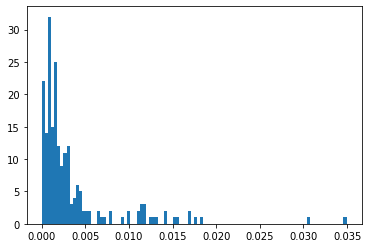

In [13]:
# percentage of 1's in each column of y
one_perc = y.apply(lambda x: x.sum()/len(y))
plt.figure()
plt.hist(one_perc, bins=100);

In [14]:
# categorical columns
col_cat = [col for col in X.columns if X[col].dtype == 'object']
col_cat

['cp_type', 'cp_dose']

In [15]:
X.cp_type.value_counts()

trt_cp         21948
ctl_vehicle     1866
Name: cp_type, dtype: int64

In [16]:
X.cp_dose.value_counts()

D1    12147
D2    11667
Name: cp_dose, dtype: int64

## Preprocessing

In [17]:
# One-hot encoding for cp_type and cp_dose
X['cp_type'].replace({'trt_cp':1., 'ctl_vehicle':0.}, inplace=True)
X['cp_dose'].replace({'D1':1., 'D2':0.}, inplace=True)

In [18]:
# split into training set and test set
ids = X.index.values.copy()
np.random.shuffle(ids)

train_perc, test_perc = 0.8, 0.2
train_id = ids[:round(len(ids)*train_perc)]
test_id = ids[round(len(ids)*train_perc)+1:]

X_train = X.loc[train_id]
X_test = X.loc[test_id]

y_train = y.loc[train_id]
y_test = y.loc[test_id]

In [19]:
# normalize the data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train))
X_train_norm.columns = X_train.columns
X_train_norm.index = X_train.index

X_test_norm = pd.DataFrame(scaler.transform(X_test))
X_test_norm.columns = X_test.columns
X_test_norm.index = X_test.index

In [20]:
X_train_norm.head()

cp_type   cp_time   cp_dose       g-0       g-1       g-2  \
sig_id                                                                     
id_eed4f5eb5 -3.451946 -1.236669  0.980918 -0.456171  0.005873  0.427600   
id_528f47dac  0.289692  0.000195  0.980918  0.450424 -0.319481 -1.396536   
id_f706afa88  0.289692  0.000195  0.980918 -1.099553 -0.396522  0.778984   
id_1bb6de988  0.289692 -1.236669  0.980918  0.036681  0.470222 -0.214747   
id_a1c138776  0.289692 -1.236669  0.980918  2.208361  1.993362 -0.351596   

                   g-3       g-4       g-5       g-6  ...      c-90      c-91  \
sig_id                                                ...                       
id_eed4f5eb5 -1.182563 -0.524187 -0.299103  0.945605  ...  0.375991  0.037446   
id_528f47dac -0.005718 -0.247520  3.341033 -0.484051  ...  0.721413  0.594174   
id_f706afa88  0.962121 -1.001836 -0.126575 -0.266299  ... -0.087900  0.444295   
id_1bb6de988 -0.247864 -0.645399  0.058925  0.002735  ...  0.867269  0.825751   
id_a1c138776  2.984833  0.780252 -0.034757  0.413108  ... -0.524355  0.430530   

                  c-92      c-93      c-94      c-95      c-96      c-97  \
sig_id                                                                     
id_eed4f5eb5 -0.282627  0.153964  0.308799  1.054493  0.141999  0.306620   
id_528f47dac  0.488883  0.341703  0.586436 -0.182267  0.546444  0.400113   
id_f706afa88  0.397154  0.733476  0.023046 -0.501745  0.458904  0.297883   
id_1bb6de988  0.473814  0.355106  0.348301  0.526270  0.141260  0.030956   
id_a1c138776  0.463650  0.653685 -0.315908 -0.252784  0.071061  0.000940   

                  c-98      c-99  
sig_id                            
id_eed4f5eb5  0.225334 -0.099044  
id_528f47dac  0.337062 -0.275528  
id_f706afa88 -0.976632 -0.523066  
id_1bb6de988  0.190197  0.451120  
id_a1c138776  0.341108  0.516565  

[5 rows x 875 columns]

## Models  

### Model 1: Neural Network

In [31]:
params_net = {'input_size': X_train_norm.shape[1],
             'hidden_size': [512, 512, 256, 128 ,256, 512, 1024],
             'output_size': y_train.shape[1],
             'dropout': 0.01}

params_fit = {'X':X_train_norm,
             'y': y_train,
             'epoch': 10,
             'lr': 5e-6,
             'batch_size':128,
             'L2': 0,
             'pos_weight':50,
             'verbose':True}

net = DenseNet(**params_net)
model = Model(net)
model.fit(**params_fit)

Epoch [1, 0] : loss 1.047478199005127
Epoch [1, 3840] : loss 1.05042564868927
Epoch [1, 7680] : loss 1.0482022762298584
Epoch [1, 11520] : loss 1.057258129119873
Epoch [1, 15360] : loss 1.056621789932251
Epoch [2, 0] : loss 1.0446748733520508
Epoch [2, 3840] : loss 1.0472965240478516
Epoch [2, 7680] : loss 1.0443134307861328
Epoch [2, 11520] : loss 1.0522059202194214
Epoch [2, 15360] : loss 1.049384593963623
Epoch [3, 0] : loss 1.031517505645752
Epoch [3, 3840] : loss 1.030834436416626
Epoch [3, 7680] : loss 1.0171416997909546
Epoch [3, 11520] : loss 1.0096237659454346
Epoch [3, 15360] : loss 0.9825803637504578
Epoch [4, 0] : loss 0.9295281767845154
Epoch [4, 3840] : loss 0.8986634016036987
Epoch [4, 7680] : loss 0.858842134475708
Epoch [4, 11520] : loss 0.8441187739372253
Epoch [4, 15360] : loss 0.8327736258506775
Epoch [5, 0] : loss 0.8097099661827087
Epoch [5, 3840] : loss 0.8154553174972534
Epoch [5, 7680] : loss 0.8103313446044922
Epoch [5, 11520] : loss 0.8212631940841675
Epoch [

In [32]:
y_train_predict = model.predict(X_train_norm, 0.45)

# print('Accuracy: ')
# print(accuracy_score(y_train, y_train_predict))
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))

print()
y_test_predict = model.predict(X_test_norm, 0.5)

# print('Accuracy: ')
# print(accuracy_score(y_test, y_test_predict))
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

Precision: 
0.05716523101018011
Recall: 
0.08687244328746746
F1: 
0.06895533843020338


In [34]:
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())

13445
20432


In [ ]:
# todo: grid search for pos_weight




### Model 2: Random Forest

In [84]:
# todo: define class-weight based 
weight_ratio = 50
class_weight = [{0:1, 1:round(len(value)/sum(value)-1)* weight_ratio} for _, value in y_train.iteritems()]

# class_weight = [{0:1, 1:50}]*y_train.shape[1]

rfc = RandomForestClassifier(n_estimators = 100,
                             max_depth = 20,
                             class_weight = 'balanced_subsample',
                             random_state=100)
rfc.fit(X_train, y_train);

In [85]:
y_train_predict = rfc.predict(X_train)

# print('Accuracy: ')
# print(accuracy_score(y_train, y_train_predict))
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))

print()

y_test_predict = rfc.predict(X_test)

# print('Accuracy: ')
# print(accuracy_score(y_test, y_test_predict))
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

Precision: 
1.0
Recall: 
0.2786165860914838
F1: 
0.4358094351695655

Precision: 
0.9689265536723164
Recall: 
0.1009417304296645
F1: 
0.1828358208955224


In [86]:
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())

13445
3746

3398
354


In [ ]:
# # Grid Search 
# parameters = {'n_estimators': [80, 100, 120],
#              'max_depth': [15, 20, 25],
#              'class_weight': [[{0:1, 1:100}]*y_train.shape[1], [{0:1, 1:150}]*y_train.shape[1]]}

# rfc = RandomForestClassifier(random_state=100)
# clf = GridSearchCV(rfc, parameters, scoring=make_scorer(f1_score, greater_is_better=True))
# clf.fit(X_train, y_train)

# print('# Tuning hyper-parameter for f1')
# print()
# print('Best parameters set found on validation set:')
# print(clf.best_params_)
# print()
# print('Grid scores on validation set: ')
# means = clf.cv_results_['mean_test_socre']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("{} ({}) for {}".format(mean, std*2, params))

### Model 3 : Classifier Chains   
#### Model 3.1 : Random Forest

In [56]:
# rfc_1 = BalancedRandomForestClassifier(n_estimators=50,
#                                      max_depth = 20, 
#                                      random_state=100)
rfc_1 = RandomForestClassifier(n_estimators = 100,
                               max_depth = 8,
                               class_weight = {0:1, 1:50},
                               n_jobs = 3,
                               random_state = 100)
clf_chain = ClassifierChain(rfc_1)
clf_chain.fit(X_train, y_train);

In [59]:
y_train_predict = clf_chain.predict(X_train).toarray()
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))
print()
y_test_predict = clf_chain.predict(X_test).toarray()
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

Precision: 
0.895001571832757
Recall: 
0.8470063220528077
F1: 
0.8703427719821162

Precision: 
0.6231060606060606
Recall: 
0.19364331959976458
F1: 
0.2954647507858105


In [58]:
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())

13445
12724.0

3398
1056.0


In [ ]:
# todo: examine each column



* Maunal impliment of classifier chain to allow dynamic class weight

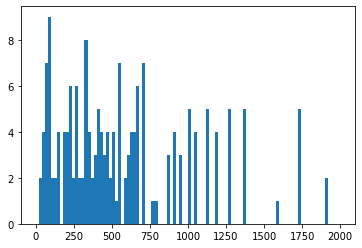

In [41]:
neg_vs_pos = [round(len(y)/sum(y)-1) for _, y in y_train.iteritems()];

plt.figure()
plt.hist(neg_vs_pos, bins=100, range = (0, 2000));

In [80]:
np.sum(np.array(neg_vs_pos)>50)

204

In [97]:
weight_ratio = 0.75
max_depth = 5

y_train_predict = np.array([])
y_test_predict = np.array([])
model_chain = []

X = X_train.values
X2 = X_test.values
for _, y in tqdm(y_train.iteritems()):
    # class_weight for each target column
    class_weight = {0:1, 1:min(round(len(y)/sum(y)-1)*weight_ratio, 8000)}
    
    rfc_2 = RandomForestClassifier(n_estimators = 100,
                                  max_depth = max_depth,
                                  class_weight = class_weight,
                                  n_jobs = 3,
                                  random_state=100);
    rfc_2.fit(X, y);
    
    y_predict = rfc_2.predict(X).reshape((-1, 1))
    y_predict2 = rfc_2.predict(X2).reshape((-1,1))
    
    if y_test_predict.size == 0:
        y_test_predict = y_predict2
    else:
        y_test_predict = np.concatenate((y_test_predict, y_predict2), axis=1)
    
    if y_train_predict.size == 0:
        y_train_predict = y_predict
    else:
        y_train_predict = np.concatenate((y_train_predict, y_predict), axis=1)
        
    X = np.concatenate((X, y_predict), axis=1)
    X2 = np.concatenate((X2, y_predict2), axis=1)
    model_chain.append(rfc_2)

206it [17:00,  4.95s/it]


In [90]:
# # inference
# y_train_predict = np.array([])
# y_test_predict = np.array([])
# X = X_train.values
# X2 = X_test.values
# for rfc_2 in model_chain:
#     y_predict = rfc_2.predict(X).reshape((-1, 1))
#     y_predict2 = rfc_2.predict(X2).reshape((-1,1))
    
#     if y_test_predict.size == 0:
#         y_test_predict = y_predict2
#     else:
#         y_test_predict = np.concatenate((y_test_predict, y_predict2), axis=1)
#     if y_train_predict.size == 0:
#         y_train_predict = y_predict
#     else:
#         y_train_predict = np.concatenate((y_train_predict, y_predict), axis=1)
#     X = np.concatenate((X, y_predict), axis=1)
#     X2 = np.concatenate((X2, y_predict2), axis=1)

In [98]:
# Classifier Chain
print('weight_ratio: ', weight_ratio, ' max_depth: ', max_depth)
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))
print()
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

weight_ratio:  0.75  max_depth:  5
Precision: 
0.7798650903024589
Recall: 
0.7997024916325771
F1: 
0.7896592244418331

Precision: 
0.49660284126003706
Recall: 
0.23660977045320777
F1: 
0.32051026509866454


In [99]:
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())

13445
13787

3398
1619


#### Model 3.2 : Logistic Regression

In [63]:
lr = LogisticRegression(penalty = 'l2',
                       C = 0.5,
                       class_weight = {0:1, 1:30},
                        n_jobs = 3,
                       random_state = 100)
clf_chain_lr = ClassifierChain(lr)
clf_chain_lr.fit(X_train_norm, y_train);

ClassifierChain(classifier=LogisticRegression(C=0.5, class_weight={0: 1, 1: 30},
                                              n_jobs=3, random_state=100),
                require_dense=[True, True])

In [64]:
y_train_predict = clf_chain_lr.predict(X_train_norm).toarray()
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))
print()
y_test_predict = clf_chain_lr.predict(X_test_norm).toarray()
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

Precision: 
0.5745586238116795
Recall: 
0.9439940498326516
F1: 
0.7143379766427467

Precision: 
0.16658516707416463
Recall: 
0.3007651559741024
F1: 
0.21441309136683098


In [65]:
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())

13445
22090.0

3398
6135.0


### Model 4: Binary Relavance    
#### Model 4.1: Random Forest

In [ ]:
rfc_1 = RandomForestClassifier(n_estimators = 100,
                               max_depth = 8,
                               class_weight = {0:1, 1:50},
                               n_jobs = 3,
                               random_state = 100)
clf_binary = BinaryRelevance(rfc_1)
clf_binary.fit(X_train, y_train);

In [ ]:
y_train_predict = clf_binary.predict(X_train).toarray()
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))
print()
y_test_predict = clf_binary.predict(X_test).toarray()
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

In [ ]:
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())

* Manual implement of binary relevance. 

In [87]:
weight_ratio = 0.7
max_depth = 6

y_train_predict = np.array([])
y_test_predict = np.array([])
model_list = []

X = X_train.values
X2 = X_test.values
scaler = StandardScaler()
for _, y in tqdm(y_train.iteritems()):
    # class_weight for each target column
    class_weight = {0:1, 1:min(round(len(y)/sum(y)-1)*weight_ratio, 8000)}
    
    rfc_2 = RandomForestClassifier(n_estimators = 100,
                                  max_depth = max_depth,
                                  class_weight = class_weight,
                                  n_jobs = 3,
                                  random_state=100);
    rfc_2.fit(X, y);
    
    y_predict = rfc_2.predict(X).reshape((-1, 1))
    y_predict2 = rfc_2.predict(X2).reshape((-1,1))
    
    if y_test_predict.size == 0:
        y_test_predict = y_predict2
    else:
        y_test_predict = np.concatenate((y_test_predict, y_predict2), axis=1)
    
    if y_train_predict.size == 0:
        y_train_predict = y_predict
    else:
        y_train_predict = np.concatenate((y_train_predict, y_predict), axis=1)
        
    model_list.append(rfc_2)

206it [21:37,  6.30s/it]


In [ ]:
# inference
# y_train_predict = np.array([])
# y_test_predict = np.array([])
# X = X_train.values
# X2 = X_test.values
# for rfc_2 in model_list:
#     y_predict = rfc_2.predict(X).reshape((-1, 1))
#     y_predict2 = rfc_2.predict(X2).reshape((-1,1))
    
#     if y_test_predict.size == 0:
#         y_test_predict = y_predict2
#     else:
#         y_test_predict = np.concatenate((y_test_predict, y_predict2), axis=1)
    
#     if y_train_predict.size == 0:
#         y_train_predict = y_predict
#     else:
#         y_train_predict = np.concatenate((y_train_predict, y_predict), axis=1)

In [88]:
# binary relevance
print('weight_ratio: ', weight_ratio, ' max_depth: ', max_depth)
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))
print()
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

weight_ratio:  0.7  max_depth:  6
Precision: 
0.9088415617941271
Recall: 
0.8379323168464113
F1: 
0.871947680043342

Precision: 
0.7120622568093385
Recall: 
0.21542083578575633
F1: 
0.33077270673294173


In [89]:
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())

13445
12396

3398
1028
